# Predicting article major field by its title

In [78]:
from lattes_html_parser import get_researchers
# Know more about lattes_html_parser: https://github.com/guilhermecxe/lattes-html-parser

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import os

## Data collection

In [2]:
DATA_PATH = 'data/researchers-by-area'

In [3]:
%%time

# Creating instances of researchers from html files using the lattes_html_parser package
researchers = []
for folder in os.listdir(DATA_PATH):
    area_path = os.path.join(DATA_PATH, folder)
    researchers += get_researchers(area_path)

print('Researchers obtained:', len(researchers))

Researchers obtained: 1300
CPU times: total: 2min 38s
Wall time: 4min 18s


In [4]:
# Example of how the researcher area of expertise is represented
researchers[54].areas_of_expertise

['Ciências Agrárias > Agronomia > Ciência do Solo > Física do Solo.',
 'Ciências Agrárias > Agronomia > Ciência do Solo > Operações Agrícolas.']

In [5]:
# Function to get researcher most frequent major field
def major_field(researcher):
    major_fields = [area.split(' > ')[0] for area in researcher.areas_of_expertise]
    major_field = max(major_fields, key=major_fields.count)
    return major_field.strip('.')

# Example
print("Researcher areas of expertise:")
print(researchers[45].areas_of_expertise)
print()
print("Researcher most frequent major field:")
print(major_field(researchers[45]))

Researcher areas of expertise:
['Ciências Agrárias > Agronomia > Ciência do Solo.', 'Ciências Agrárias > Agronomia > Ciência do Solo > Gênese, Morfologia e Classificação dos Solos.', 'Ciências Agrárias > Agronomia > Ciência do Solo > Manejo e Conservação do Solo.', 'Ciências Agrárias > Agronomia > Ciência do Solo > Levantamento de Solos.', 'Ciências Agrárias > Agronomia > Ciência do Solo > Mineralogia dos Solos.', 'Ciências Agrárias > Agronomia > Ciência do Solo > Zoneamento Agroecológico.']

Researcher most frequent major field:
Ciências Agrárias


In [6]:
columns = ['researcher_name', 'researcher_lattes_id', 'researcher_major_field', 'article_title']
articles_and_fields_df = pd.DataFrame(columns=columns)

rows = []
for researcher in researchers:
    name = researcher.name
    lattes_id = researcher.lattes_id
    researcher_major_field = major_field(researcher)
    for article in researcher.complete_articles:
        title = article.title
        if title: # Some articles don't have title
            rows.append({
                'researcher_name': name,
                'researcher_lattes_id': lattes_id,
                'researcher_major_field': researcher_major_field,
                'article_title': title
            })
articles_and_fields_df = pd.concat([articles_and_fields_df, pd.DataFrame(rows)], ignore_index=True)
        
print('Dataframe shape:', articles_and_fields_df.shape)
articles_and_fields_df.head()

Dataframe shape: (10390, 4)


,researcher_name,researcher_lattes_id,researcher_major_field,article_title
0,Juarez Morbini Lopes,2612407908632983,Ciências Agrárias,Níveis das vitaminas A e E em dietas de frango...
1,Juarez Morbini Lopes,2612407908632983,Ciências Agrárias,Adição de bentonita sódica como adsorvente de ...
2,Juarez Morbini Lopes,2612407908632983,Ciências Agrárias,Níveis de substituição da DL-metionina pela me...
3,Juarez Morbini Lopes,2612407908632983,Ciências Agrárias,Enzimas de função hepática na aflatoxicose agu...
4,Juarez Morbini Lopes,2612407908632983,Ciências Agrárias,"Efeitos de Níveis das VitaminasA, E, Piridoxin..."


## Engineering and analysis

### Repeated articles

In [7]:
# Removing repeated occurrences of article and major field
# But I am keeping it if, for example, an article is the curriculum of two researchers from two differente major fields
articles_and_fields_df.drop_duplicates(['researcher_major_field', 'article_title'], inplace=True, ignore_index=True)
print("New shape:", articles_and_fields_df.shape)

New shape: (10255, 4)


### One-hot encoding

In [8]:
# Converting the titles in an one-hot matrix
vec = CountVectorizer(binary=True, strip_accents='unicode', stop_words=['english', 'portuguese'],
                      min_df=2, dtype=np.int8)

data = vec.fit_transform(articles_and_fields_df['article_title']).toarray()
features = vec.get_feature_names_out()

one_hot = pd.DataFrame(data, columns=features)
print('Shape:', one_hot.shape)
one_hot.head()

Shape: (10255, 9624)


,001,01,0157,02,03,10,100,101,108,1080,...,zinco,zinnia,zirconio,zirconium,zn,zona,zoneamento,zro2,zum,zvs
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Articles with little meaning

In [9]:
no_significant_words = (one_hot.sum(axis=1) == 0)
no_significant_words_count = no_significant_words.sum()
print("Count of articles with no words represented: ", no_significant_words_count)

Count of articles with no words represented:  38


In [10]:
# A sample of those article without meaning words
df = pd.concat([articles_and_fields_df, one_hot], axis=1)
df[no_significant_words].article_title.head(10)

921                              Calcificação Metastática
1109    Einfluss unterschiedlicher Betreuungsintensitä...
2633                                        Balsaminaceas
2634                                            Ericaceas
2715                          Where feral pigeons differ.
3708                                 Embolia amniocaseosa
3901                                     Colite Isquêmica
3916                         Espondilodiscite piogênica. 
4066                            PICNODIOSTOSE E EPILEPSIA
4163                                     Barotrauma Ótico
Name: article_title, dtype: object

In [11]:
# Removing the articles with meaningful titles
no_significant_words_index = df[no_significant_words].index
df.drop(index=no_significant_words_index, inplace=True)
print("New shape:", df.shape)

New shape: (10217, 9628)


### Counts

In [12]:
print("Count of researchers:", df['researcher_lattes_id'].nunique())

Count of researchers: 902


In [13]:
cols = ['researcher_lattes_id', 'researcher_major_field']
researcher_major_field = df[cols].groupby(
    'researcher_lattes_id', as_index=False).apply(lambda x: x.mode()).reset_index(drop=True)

print('Researchers by major field:')
researcher_major_field['researcher_major_field'].value_counts()

Researchers by major field:


Ciências Humanas               207
Ciências Sociais Aplicadas     157
Engenharias                    137
Ciências Biológicas             90
Ciências Agrárias               88
Ciências da Saúde               78
Ciências Exatas e da Terra      76
Lingüística, Letras e Artes     69
Name: researcher_major_field, dtype: int64

In [14]:
# Articles by researcher major field
df['researcher_major_field'].value_counts()

Ciências Biológicas            1831
Ciências Humanas               1750
Ciências Agrárias              1605
Ciências Sociais Aplicadas     1230
Ciências Exatas e da Terra     1156
Ciências da Saúde              1099
Engenharias                     959
Lingüística, Letras e Artes     587
Name: researcher_major_field, dtype: int64

### Model input

In [90]:
# Getting the data to be used in the prediction model
# The number of sampels by major field is the lowest number of articles in one field
# But actually, using all the data seems to make the model perform better in most of the fields

# num_samples = df['researcher_major_field'].value_counts().min()
# sampled_df = df.groupby('researcher_major_field', as_index=False).apply(lambda x: x.sample(n=num_samples))
# sampled_df.reset_index(drop=True, inplace=True)
# sampled_df['researcher_major_field'].value_counts()

In [91]:
# Transforming the major fields in numbered labels
le = LabelEncoder()
df['major_field_label'] = le.fit_transform(df['researcher_major_field'])

In [92]:
# Using 90% of the data to train and 10% to test
X = df[features]
y = df['major_field_label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)

## Trainig

### Logistic regression

In [93]:
clf = LogisticRegression(random_state=0, max_iter=200)
clf.fit(X_train, y_train)

LogisticRegression(max_iter=200, random_state=0)

#### Evaluation

In [94]:
print("Train score:", clf.score(X_train, y_train))

Train score: 0.9634584013050571


In [95]:
print("Test score:", clf.score(X_test, y_test))

Test score: 0.7583170254403131


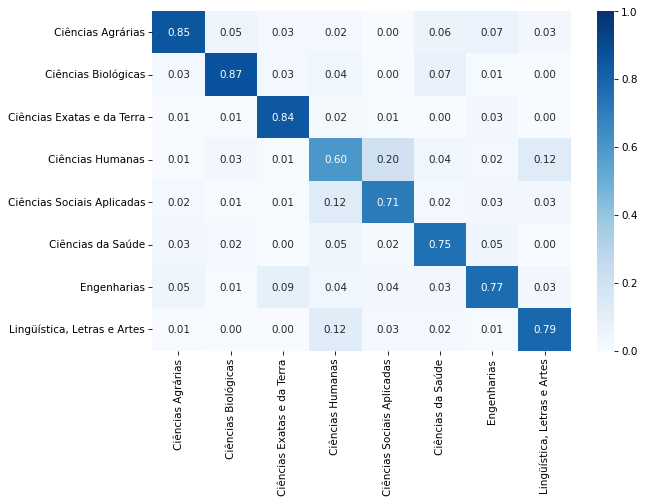

In [96]:
# Confusion matrix
expected = y_test
predicted = clf.predict(X_test)

cm = confusion_matrix(expected, predicted)
cm_df = pd.DataFrame(cm, columns=le.classes_, index=le.classes_)

plt.figure(figsize=(9, 6), dpi=75)
sns.heatmap(cm_df / cm_df.sum(axis=0), cmap='Blues', vmax=1.0, annot=True, fmt='.02f');

## Prediction examples

In [103]:
def predict_random_test_article():
    sample = X_test.sample(n=1, random_state=None)
    sample_i = sample.index[0]
    proba = clf.predict_proba(sample[features])

    print('Article:', df.iloc[sample_i]['article_title'])
    print('Researcher field:', df.iloc[sample_i]['researcher_major_field'])
    print()
    print('Chances:')
    for i, class_ in enumerate(le.classes_):
        print('{:.2f}'.format(proba[0][i]), '\t', class_)
        
predict_random_test_article()

Article: Apneia da prematuridade.
Researcher field: Ciências da Saúde

Chances:
0.07 	 Ciências Agrárias
0.04 	 Ciências Biológicas
0.03 	 Ciências Exatas e da Terra
0.17 	 Ciências Humanas
0.10 	 Ciências Sociais Aplicadas
0.42 	 Ciências da Saúde
0.03 	 Engenharias
0.14 	 Lingüística, Letras e Artes


In [105]:
predict_random_test_article()

Article: Escola Supletiva
Researcher field: Ciências Humanas

Chances:
0.02 	 Ciências Agrárias
0.07 	 Ciências Biológicas
0.05 	 Ciências Exatas e da Terra
0.20 	 Ciências Humanas
0.26 	 Ciências Sociais Aplicadas
0.06 	 Ciências da Saúde
0.20 	 Engenharias
0.14 	 Lingüística, Letras e Artes


In [107]:
predict_random_test_article()

Article: A new look at the hemolytic effect of local anesthetics, considering their real membrane/water partitioning at pH 7.4
Researcher field: Ciências Biológicas

Chances:
0.03 	 Ciências Agrárias
0.76 	 Ciências Biológicas
0.05 	 Ciências Exatas e da Terra
0.01 	 Ciências Humanas
0.01 	 Ciências Sociais Aplicadas
0.09 	 Ciências da Saúde
0.04 	 Engenharias
0.00 	 Lingüística, Letras e Artes
